In [5]:
# Importar librerías necesarias
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Para graficar superficies 3D si es necesario

%matplotlib inline

In [6]:
# Cargar el dataset (asumiendo que 'adult.csv' está en el directorio actual)
data = pd.read_csv('adult.csv')

# Preprocesar: Mapear 'income' a numérico (0 para <=50K, 1 para >50K)
data['income'] = data['income'].map({'<=50K': 0, '>50K': 1})

# Seleccionar características numéricas relevantes
X = data[['age', 'educational-num', 'hours-per-week']].values
y = data['income'].values
m = y.size

print(f'Número de ejemplos de entrenamiento: {m}')
# Imprimir algunos puntos de datos
print('{:>8s}{:>8s}{:>8s}{:>10s}'.format('X[:,0]', 'X[:,1]', 'X[:,2]', 'y'))
print('-'*40)
for i in range(10):
    print('{:8.0f}{:8.0f}{:8.0f}{:10.0f}'.format(X[i, 0], X[i, 1], X[i, 2], y[i]))

Número de ejemplos de entrenamiento: 48842
  X[:,0]  X[:,1]  X[:,2]         y
----------------------------------------
      25       7      40         0
      38       9      50         0
      28      12      40         1
      44      10      40         1
      18      10      30         0
      34       6      30         0
      29       9      40         0
      63      15      32         1
      24      10      40         0
      55       4      10         0


In [7]:
def featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

# Normalizar X
X_norm, mu, sigma = featureNormalize(X)
print('Media calculada:', mu)
print('Desviación estándar calculada:', sigma)
print(X_norm[:5])  # Imprimir primeras 5 filas normalizadas

Media calculada: [38.64358544 10.07808853 40.42238238]
Desviación estándar calculada: [13.71036958  2.57094644 12.39131717]
[[-0.99512893 -1.19725891 -0.03408696]
 [-0.04694151 -0.41933527  0.77292975]
 [-0.77631645  0.74755018 -0.03408696]
 [ 0.39068346 -0.03037346 -0.03408696]
 [-1.50569139 -0.03037346 -0.84110367]]


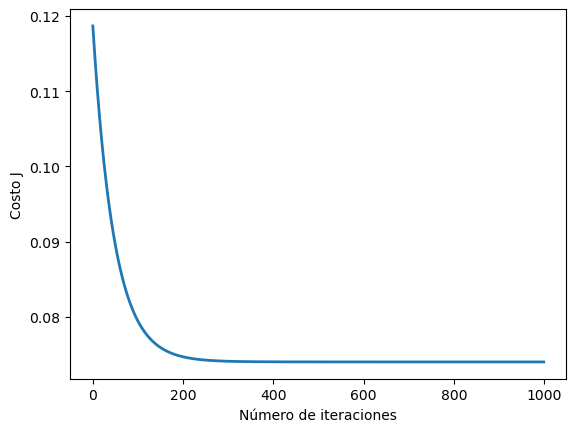

Theta calculado por descenso por gradiente: [0.23927144 0.08912764 0.12876006 0.07226747]
Predicción de income (probabilidad >50K) para [age=30, edu=10, hours=40]: 0.1767


In [8]:
def computeCostMulti(X, y, theta):
    m = y.shape[0]
    h = np.dot(X, theta)
    J = (1 / (2 * m)) * np.sum(np.square(h - y))
    return J

def gradientDescentMulti(X, y, theta, alpha, num_iters):
    m = y.shape[0]
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        h = np.dot(X, theta)
        theta = theta - (alpha / m) * np.dot(X.T, (h - y))
        J_history.append(computeCostMulti(X, y, theta))

    return theta, J_history

# Agregar columna de unos a X_norm
X_ready = np.concatenate([np.ones((m, 1)), X_norm], axis=1)

# Elegir alpha y número de iteraciones
alpha = 0.01
num_iters = 1000

# Inicializar theta
theta = np.zeros(X_ready.shape[1])

# Ejecutar descenso por gradiente
theta, J_history = gradientDescentMulti(X_ready, y, theta, alpha, num_iters)

# Graficar la convergencia
plt.plot(np.arange(len(J_history)), J_history, lw=2)
plt.xlabel('Número de iteraciones')
plt.ylabel('Costo J')
plt.show()

print('Theta calculado por descenso por gradiente:', theta)

# Predicción de ejemplo: Persona de 30 años, education-num=10, hours-per-week=40
x_sample = np.array([30, 10, 40])
x_sample_norm = (x_sample - mu) / sigma
x_sample_ready = np.concatenate([np.ones(1), x_sample_norm])
prediction = np.dot(x_sample_ready, theta)
print(f'Predicción de income (probabilidad >50K) para [age=30, edu=10, hours=40]: {prediction:.4f}')

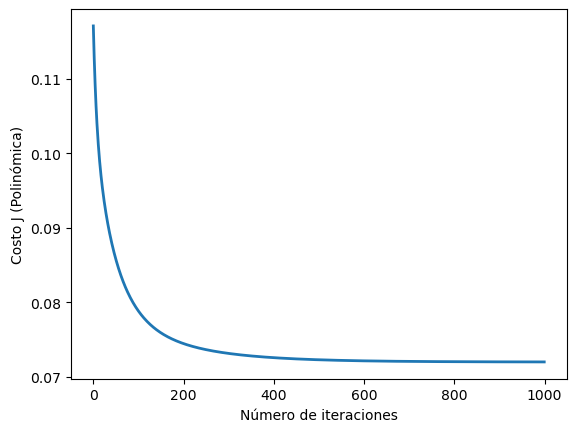

Theta calculado por descenso por gradiente (Polinómica): [ 0.24811564  0.102662    0.1326066   0.05631581 -0.03674833  0.02817992
 -0.00239131]
Predicción polinómica de income para [age=30, edu=10, hours=40]: 0.1629


In [9]:
def polyFeatures(X, degree):
    X_poly = np.ones((X.shape[0], 1))  # Columna de bias
    for d in range(1, degree + 1):
        for i in range(X.shape[1]):
            X_poly = np.concatenate((X_poly, np.power(X[:, i:i+1], d)), axis=1)
    return X_poly

# Expandir a grado 2
degree = 2
X_poly = polyFeatures(X_norm, degree)

# Inicializar theta para polinómica
theta_poly = np.zeros(X_poly.shape[1])

# Ejecutar descenso por gradiente para polinómica
theta_poly, J_history_poly = gradientDescentMulti(X_poly, y, theta_poly, alpha, num_iters)

# Graficar convergencia
plt.plot(np.arange(len(J_history_poly)), J_history_poly, lw=2)
plt.xlabel('Número de iteraciones')
plt.ylabel('Costo J (Polinómica)')
plt.show()

print('Theta calculado por descenso por gradiente (Polinómica):', theta_poly)

# Predicción polinómica para el ejemplo
x_sample_norm_poly = polyFeatures(x_sample_norm.reshape(1, -1), degree).flatten()
prediction_poly = np.dot(x_sample_norm_poly, theta_poly)
print(f'Predicción polinómica de income para [age=30, edu=10, hours=40]: {prediction_poly:.4f}')

In [10]:
def normalEqn(X, y):
    theta = np.zeros(X.shape[1])
    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
    return theta

# Usar X_ready (con unos y normalizado)
theta_normal = normalEqn(X_ready, y)
print('Theta calculado por ecuación de la normal:', theta_normal)

# Predicción con ecuación normal para el ejemplo
prediction_normal = np.dot(x_sample_ready, theta_normal)
print(f'Predicción con ecuación normal de income para [age=30, edu=10, hours=40]: {prediction_normal:.4f}')

Theta calculado por ecuación de la normal: [0.23928177 0.08913102 0.1287669  0.07226099]
Predicción con ecuación normal de income para [age=30, edu=10, hours=40]: 0.1767
